In [1]:
import random
from numpy.random import rand
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
genesis_states = {
    'Reservoir_Capacity': 73000,        # The total amount of water that the reservoir can hold.
    'Reservoir_Level': 0,               # The starting amount of water within the reservoir.
    'Reserve_Percent': .05,             # A variable that will be updated with each time step that keeps track of how much of the water flowing through the dam to hold back to fill the reservoir.
    'Current_Month': 0,                 # Tracks what month the model is in so that the proper river water level can be pulled.
    'Number_of_Years': 0                # Tracks how many years it takes to fill the reservoir.
}

In [3]:
df = pd.DataFrame({
    'Month':['January','February','March','April','May','June','July','August','September','October','November','December'],
    'River_Water_Flow':[724,448,406,427,503,1084,4989,15237,13625,7130,2451,1257],
    'River_Two_Water_Flow':[2469,1905,2014,2225,2026,1792,1368,1435,2236,3024,2786,2747],
    'River_Three_Water_Flow':[17,6,1,3,8,88,1536,5126,3306,770,145,46],
    'Total_Water_Flow':[3210,2359,2421,2655,2537,2964,7893,21798,19167,10924,5382,4050]
  
})

In [4]:
def Dam_Policy(params, step, sL, s):
  f = 0
  m = s['Current_Month']

  if s['Reservoir_Level'] < s['Reservoir_Capacity']:
    f = df.at[m, 'River_Water_Flow'] * s['Reserve_Percent']
    if m == 11:
      u = -11
      y = 1
    else:
      u = 1
      y = 0
    return({'Dam_Reserve': f, 'Month_Update': u, 'Year_Update': y})
  else:
    f = 0
    if m == 11:
      u = -11
      y = 0
    else:
      u = 1
      y = 0
    return({'Dam_Reserve': f, 'Month_Update': u, 'Year_Update': y})

In [5]:
def Reservoir_Update(params, step, sL, s, _input):
  k = 'Reservoir_Level'
  v = s['Reservoir_Level'] + _input['Dam_Reserve']
  return (k,v)

def Month_Update(params, step, sL, s, _input):
  k = 'Current_Month'
  v = s['Current_Month'] + _input['Month_Update']
  return (k,v)

def Year_Update(params, step, sL, s, _input):
  k = 'Number_of_Years'
  v = s['Number_of_Years'] + _input['Year_Update']
  return (k,v)

In [6]:
partial_state_update_blocks = [
    {
        'policies': {
            Dam_Policy
        },    
        'variables': {
            'Reservoir_Level': Reservoir_Update,
            'Current_Month': Month_Update,
            'Number_of_Years' : Year_Update
        }
    }
]

In [7]:
simulation_parameters = {
    'T': range(500),
    'N': 1,
    # 'M': {}
}

In [8]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment


exp = Experiment()
c = config_sim(simulation_parameters)
exp.append_configs(   
    
    initial_state=genesis_states,
    partial_state_update_blocks=partial_state_update_blocks,
    sim_configs=c 
)

In [9]:
%matplotlib inline
from cadCAD.engine import ExecutionMode, ExecutionContext
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)

from cadCAD.engine import Executor
from cadCAD import configs
simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_system_events, tensor_field, sessions = simulation.execute() 
import pandas as pd
df = pd.DataFrame(raw_system_events)
df.set_index(['run', 'timestep', 'substep'])


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (500, 1, 1, 5)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.02s


Reservoir_Capacity  Reservoir_Level  Reserve_Percent  \
run timestep substep                                                         
1   0        0                     73000             0.00             0.05   
    1        1                     73000            36.20             0.05   
    2        1                     73000            58.60             0.05   
    3        1                     73000            78.90             0.05   
    4        1                     73000           100.25             0.05   
...                                  ...              ...              ...   
    496      1                     73000         73612.40             0.05   
    497      1                     73000         73612.40             0.05   
    498      1                     73000         73612.40             0.05   
    499      1                     73000         73612.40             0.05   
    500      1                     73000         73612.40             0.05   

                      Current_Month  Number_of_Years  simulation  subset  
run timestep substep                                                      
1   0        0                    0                0           0       0  
    1        1                    1                0           0       0  
    2        1                    2                0           0       0  
    3        1                    3                0           0       0  
    4        1                    4                0           0       0  
...                             ...              ...         ...     ...  
    496      1                    4               30           0       0  
    497      1                    5               30           0       0  
    498      1                    6               30           0       0  
    499      1                    7               30           0       0  
    500      1                    8               30           0       0  

[501 rows x 7 columns]

<AxesSubplot:xlabel='timestep'>

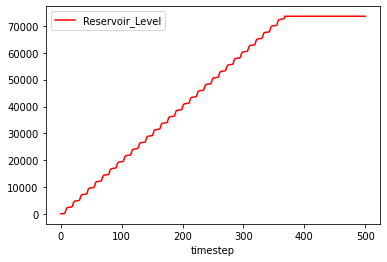

In [10]:
df.plot(x ='timestep', y=['Reservoir_Level'], kind = 'line', color = 'red')